In [1]:
import numpy as np
import pandas as pd

import pickle
import re

import networkx as nx
%matplotlib ipympl
import matplotlib.pyplot as plt
%matplotlib ipympl

from geopy.geocoders import Nominatim
import osmnx as ox

#import geopandas as gpd
#import shapely.geometry

#import plotly.express as px

# Extracting data points from a complete street directory text file

## False starts
My first attempts with regex were a bit too complex:

In [2]:
# draft/pseudo-function
#def bsd_txt_to_df(txt_file):
#     df_address_gather = pd.DataFrame(columns=['address_id', 'door_num', 'street_side', 'sub_street', 'street', 'off_street', 'to_street', 'part_of_street', 'intersects', 'occupant_last', 'occupant_first', 'occupation'])
#     for line in txt_file:
#         current_street = None
#         current_sub_street = None
        #if the line is followed by another line beginning 'See',
            #ignore both lines
        #if the line follows a blank line, is less than five words long, is followed by a line containing 'to' or 'Off', 
            #add it to column 'street' and update current_street to store it for use in the next houses
            #add the text on the following line after 'Off' or before 'to' in 'off_street'. Add text after 'to' to 'to_street'
        #if it begins '                    ',
            #add it to column 'sub_street' and update current_sub_street to store it for use in the next houses
        #if it begins with no or multiple spaces then a number,
            #strip spaces and '.' and store the number including up to one letter occuring before the '.' in 'door_num'
        #or if it starts with multiple spaces, store a NaN in 'door_num'
        #then from the same line, store in the same row the text up to the first comma in 'occupant_last', and after the last comma in 'occupation', and after the second comma in 'occupant_first'
        #or if the line starts with multpile '.' and contains 'intersects', store the rest of the text in 'intersects'
        #for each row store current_street in 'street' and current_sub_street in 'sub_street'
        #give each row a sequential 'address_id' of even numbers only
        #return df_address_gather
        
        
        #TODO: deal with [left side], [right side]

In [3]:
# # function to read and use regex to recognise relationships
# def bsd_txt_to_df(txt_file_path):
#     #load file into memory
#     with open(txt_file_path) as file:
#         txt_file = file.readlines()
#     df_address_gather = pd.DataFrame(columns=['address_id', 'door_num', 'street_side', 'sub_street', 'street', 'off_street', 'to_street', 'part_of_street', 'intersects', 'occupant_last', 'occupant_first', 'occupation'])
#     current_street = current_sub_street = off_street = to_street = door_num = occupant_last = occupant_first = occupation = intersects = ''
#     iter_txt_file = iter(txt_file)

#     address_regex = r'^\s*(\d+[A-Za-z]?(?:\s*[\&\s]+\s*\d+[A-Za-z]?)?(?:[.\u00BD])?)?\s*' #TODO: fix
        
#     for line in iter_txt_file:
#         # store the next line for context
#         next_line = next(iter_txt_file, '')
        
#         # check if the line is a street heading and store if so
#         if len(line.split()) < 5 and (' to ' in next_line or next_line.startswith('Off ')): #and not any(i.isdigit() for i in next_line) 
#             current_street = line.strip()
#             current_sub_street = ''
#             #TODO: regex to store street Off and to values

#         # check if line is a sub-street and store if so, place to current one if not
#         elif line.startswith('                    '):
#             current_sub_street = line.strip()

#         # check for intersects
#         elif 'intersects' in line.lower():
#             intersects = line.strip()

#         #TODO: check for house with door number (number and letter/&/half/comma followed by a dot) or no door number (some spaces?)
#         # elif re.match(address_regex, line):
#         #     parts = line.re()...... ## REDO
#         #     door_num = parts[1].strip() if parts[1] else ''
#         #     rest = parts[2].split(',', 2)
#         #     occupant_last = rest[0].strip() if rest else ''
#         #     if len(rest) > 1:
#         #         rest_parts = rest[1].split(',', 1)
#         #         occupant_first = rest_parts[0].strip()
#         #         occupation = rest_parts[1].strip() if len(rest_parts) > 1 else ''
#         #     else: occupation = occupant_first = ''

#         # add line to df
#         df_address_gather.loc[len(df_address_gather)] = {
#             'address_id': len(df_address_gather) * 2, #add alternating IDs in case of squeezing things in sequence
#             'street': current_street,
#             'off_street': off_street,
#             'to_street': to_street,
#             'sub_street': current_sub_street,
#             'door_num': door_num,
#             'occupant_last': occupant_last,
#             'occupant_first': occupant_first,
#             'occupation': occupation,
#             'intersects': intersects
#         }
#     return df_address_gather

# df_addresses = bsd_txt_to_df('./data/1877-BSD')
# df_addresses


If regex is too cumbersome, I considered that an alternative might be to list all street endings. However, not all contain a standard ending, such as 'Bridge End' or 'Short Strand'.

In [4]:
# street_types = ['Street', 'Road', 'Entry', 'Court', 'Place', 'Terrace', 'Row', ]


## Convert lines to data points
I first create a function to ingest a file and return a normal DataFrame. As each line/address from the text file should become a node, I simply focus on extracing them line-by-line, and storing the property of 'street':

In [5]:
# # first function to read lines as nodes and assign street headings as a property
# def bsd_txt_to_df_basic_nodes(txt_file_path):
#     #load file into memory
#     with open(txt_file_path) as file:
#         txt_file = file.readlines()
#     iter_txt_file = iter(txt_file)
#     df_node_gather = pd.DataFrame(columns=['street', 'node_info'])
#     current_street = node_info = ''
           
#     for line in iter_txt_file:

#         if line.strip() == '':
#             continue
        
#         # check if the line is a street heading and store if so
#         next_line = next(iter_txt_file, '') # store the next line for context if there is one
#         if len(line.split()) < 5 and (' to ' in next_line or next_line.startswith('Off ')): #and not any(i.isdigit() for i in next_line) 
#             current_street = line.strip()
            
#         # check for intersects
#         elif 'intersects' in line.lower():
#             node_info = line.strip()
        
#         #store anything else as node_info
#         else:
#             node_info = line #retaining whole line for now as formatting has clues

#         # add line to df
#         df_node_gather.loc[len(df_node_gather)] = {
#             'street': current_street,
#             'node_info': node_info
#         }
#     return df_node_gather

Next I add a few more fields and rules to deal with lines that should not be nodes, storing some of their information in additonal fields:

In [7]:
def bsd_txt_to_df_basic_nodes(txt_file_path):
    with open(txt_file_path) as file:
        txt_file = file.readlines()

    df_node_gather = pd.DataFrame(columns=['street', 'side', 'node_info', 'node_type'])
    current_street = node_info = ''
    i = 0 

    while i < len(txt_file):
        line = txt_file[i]
        next_line = txt_file[i + 1] if i + 1 < len(txt_file) else '' #with EOF protection

        # detect street renaming and ignore
        if line.strip() == '' or line.startswith('[Late ') or line.startswith('(Late '):
            i += 1
            continue
        
        # detect street based on next line contents and just assign to variable for now; store from-to intersections
        if len(line.split()) < 5 and not '[' in line and (' to ' in next_line or next_line.startswith('Off ')) \
            and not any(char.isdigit() for char in next_line) and not ',' in next_line\ #edge cases
                and not 'door to' in next_line and not 'entrance to' in next_line:
            
                # crudely solve edge case of an extra line for district; skip back one line to get 'street'
                if line.strip() == 'Mountpottinger' or line.strip() == 'Ballymacarrett': 
                    line = txt_file[i -1]
                side = '' #TODO: get rid of side or store it?
                current_street = line.strip()
                node_info = next_line.strip()
                node_type = 'from-to'
                i += 1 # increment i an extra time to avoid processing next line twice
        
        # crude detect lines only denoting side of street
        elif ']' in line:
            side = line.strip()
            i += 1
            continue

        # detect sub-street and store the next line, its parent, as the street instead
        elif len(line.split()) < 5 and (next_line.startswith('See ')):
            current_street = next_line.replace('See ', '')
            node_info = line
            node_type = 'sub-street'
            i += 1  # increment i an extra time to avoid processing next line twice
        
        # store expicit intersections as nodes and mark them as such
        elif 'intersect' in line.lower():
            node_info = line.strip(".").replace(' intersects', '').replace(' intersect', '').replace('\n', '')
            node_type = 'intersect'
        
        else:
            node_info = line.strip()

        df_node_gather.loc[len(df_node_gather)] = {
            'street': current_street,
            'side': side,
            'node_info': node_info,
            'node_type': node_type
        }

        # reset per-record variables and increment
        node_info = node_type = ''
        i += 1

    return df_node_gather


I assigned the DataFrame output of the function to `df_basic_nodes` and pickled the result to save computation time.

In [8]:
#df_basic_nodes = bsd_txt_to_df_basic_nodes('./data/1877-BSD')
#df_basic_nodes.to_pickle('./data/df_basic_nodes.pkl')
df_basic_nodes = pd.read_pickle('./data/df_basic_nodes.pkl')
df_basic_nodes


,street,side,node_info,node_type
0,Abbey Street,,North King Street to Peter's Hill,from-to
1,Abbey Street,,"1. Donaldson, Wm.",
2,Abbey Street,,"3. Craggan, John, musician",
3,Abbey Street,,"5. Ireland, Alex., flax dresser",
4,Abbey Street,,"7. Long, John",
...,...,...,...,...
38372,Zetland Street,,"14. Pritchard, Mrs.",
38373,Zetland Street,,"8. Clarke, James, her Majesty's Court of Probate",
38374,Zetland Street,,"6. Morrow, Mrs.",
38375,Zetland Street,,"4. Lynas, Joseph, boot maker",


Due to inconsistencies in formatting, the function does not yet capture all the data. However, the vast majority is present and it should suffice for graphing.

Here is an extract of the 2929 street intersections, with the streets listed in 'node_info' separated into their own fields:

In [44]:
df_connections = df_basic_nodes[df_basic_nodes['node_type'].isin(['intersect', 'from-to'])][['street', 'node_type', 'node_info']]

df_connections[['from', 'to']] = df_connections['node_info'].str.split(' to ', n=1, expand=True)
df_connections['from'] = df_connections['from'].str.replace('Off ', '')
df_connections['node_type'] = df_connections.apply(lambda row: 'off' if row['node_info'].startswith('Off ') else row['node_type'], axis=1)

df_connections

,street,node_type,node_info,from,to
0,Abbey Street,from-to,North King Street to Peter's Hill,North King Street,Peter's Hill
53,Abbey Street West,from-to,St. Paul Street to Hanna Street,St. Paul Street,Hanna Street
60,Abbot Street,off,Off Peveril Street,Peveril Street,None
73,Abercorn Street,from-to,Claremont Street to Camden Street,Claremont Street,Camden Street
80,Abercorn Street North,from-to,Leeson Street to Grosvenor Street,Leeson Street,Grosvenor Street
...,...,...,...,...,...
38349,York Street,intersect,Frederick Street,Frederick Street,None
38356,York Street,intersect,York Lane,York Lane,None
38365,Young's Place,off,Off Newtownards Road,Newtownards Road,None
38367,Young's Row,off,Off Newtownards Road,Newtownards Road,None


I join the above addresses with their derived properties with the original dataframe into `df_nodes`, where they will become features which indicate which nodes are intersection nodes and which second streets they intersect:

In [139]:
df_nodes = df_basic_nodes.join(df_connections[['node_type', 'from', 'to']], lsuffix='_old')
df_nodes.drop(columns=['node_type_old'], inplace=True)
df_nodes

,street,side,node_info,node_type,from,to
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,Peter's Hill
1,Abbey Street,,"1. Donaldson, Wm.",NaN,NaN,NaN
2,Abbey Street,,"3. Craggan, John, musician",NaN,NaN,NaN
3,Abbey Street,,"5. Ireland, Alex., flax dresser",NaN,NaN,NaN
4,Abbey Street,,"7. Long, John",NaN,NaN,NaN
...,...,...,...,...,...,...
38372,Zetland Street,,"14. Pritchard, Mrs.",NaN,NaN,NaN
38373,Zetland Street,,"8. Clarke, James, her Majesty's Court of Probate",NaN,NaN,NaN
38374,Zetland Street,,"6. Morrow, Mrs.",NaN,NaN,NaN
38375,Zetland Street,,"4. Lynas, Joseph, boot maker",NaN,NaN,NaN


In [140]:
df_nodes[df_nodes['street']=='Abbey Street West']

,street,side,node_info,node_type,from,to
53,Abbey Street West,,St. Paul Street to Hanna Street,from-to,St. Paul Street,Hanna Street
54,Abbey Street West,,"1. Graham, John, gasfitter",NaN,NaN,NaN
55,Abbey Street West,,"2. Todd, Hugh",NaN,NaN,NaN
56,Abbey Street West,,"3. White, Jos., spinning master",NaN,NaN,NaN
57,Abbey Street West,,"4. Conalty, James, clerk",NaN,NaN,NaN
58,Abbey Street West,,"5. Adamson, Joseph",NaN,NaN,NaN


On streets that are marked as running from one street to another street ('from-to') I also want to split the intersection node into 'from' and 'to' and add one node the end of the street, so that the start and end nodes of the street appear in sequential order. For simplicity, I add another column called 'second_street' to store the intersecting street, regardless of type.

In [141]:
# add an extra from-to node at the end of each street group
def add_second_from_to_node(grouped_street):
    if 'from-to' in grouped_street['node_type'].values:
        from_to_row = grouped_street[grouped_street['node_type'] == 'from-to'].iloc[0].copy()
        from_to_row['from'] = np.nan
        from_to_row['node_type'] = 'from-to-inverse'
        grouped_street.loc[grouped_street['node_type'] == 'from-to', 'to'] = np.nan
        grouped_street = pd.concat([grouped_street, from_to_row.to_frame().transpose()], ignore_index=True)
    return grouped_street

# apply function to each grouped street to obtain end node
df_nodes = df_nodes.groupby('street').apply(add_second_from_to_node).reset_index(drop=True)

#store the intersecting street, regardless of type
df_nodes['second_street'] = df_nodes['from'].combine_first(df_nodes['to'])

Now we have a structured street format, which can show how a street starts at a street, contains some addresses, intersects with some streets, and ends at another street (albeit with street sides and odd/even door number order ignored). Let's view the structured version of Abbey Street West. It originally appeared as:
```text
Abbey Street West
St. Paul Street to Hanna Street

   1. Graham, John, gasfitter
   2. Todd, Hugh
   3. White, Jos., spinning master
   4. Conalty, James, clerk
   5. Adamson, Joseph
```

In [196]:
df_nodes[df_nodes['street']=='Abbey Street West']

,street,side,node_info,node_type,from,to,second_street
54,Abbey Street West,,St. Paul Street to Hanna Street,from-to,St. Paul Street,NaN,St. Paul Street
55,Abbey Street West,,"1. Graham, John, gasfitter",NaN,NaN,NaN,NaN
56,Abbey Street West,,"2. Todd, Hugh",NaN,NaN,NaN,NaN
57,Abbey Street West,,"3. White, Jos., spinning master",NaN,NaN,NaN,NaN
58,Abbey Street West,,"4. Conalty, James, clerk",NaN,NaN,NaN,NaN
59,Abbey Street West,,"5. Adamson, Joseph",NaN,NaN,NaN,NaN
60,Abbey Street West,,St. Paul Street to Hanna Street,from-to-inverse,NaN,Hanna Street,Hanna Street


What about a street with internal intersections?
```text
Thompson Street
Off Short Strand

   1. Thompson, Thos., van driver
   3. Donigan, Thos., lighter owner
   5. Rainey, John, weigh master
   7. Nixon, Francis, engineer
..........Woodstock Street intersects
   9. McCormick, Jas., carpenter
 11. Ferguson, Robert, pattern maker
 13. Woodside, Wm., dealer
 17. Doyle, Mrs.
 19. Sherlock, Patrick, printer
 21. Donnelly, Arthur, engraver
 23. Geddis, Thos., manager
 25. Shaw, John, clerk
 27. Crenny, Joseph, jeweller
 29. Lovell, Edmond, retired inland revenue officer
 31. Waddell, Wm., bookkeeper
                               __________

 32. Thompson, John, carpenter
 30. Anderson, Thos., clerk
 28. Clark, Mrs.
 26. Montgomery, Henry, tailor
 24. Cammack, Thos., pensioner
 22. Maxwell, John, printer
 20. Martin, Thos., warehouseman
 18. Maginnes, Danl., carpenter
 16. Lytle, John, grocer
..........White Street intersects
   8. Gibson, Matthew, mechanic
   6. McDonald, Robt., van driver
   4. Wason, John, R.I.C.
```

In [195]:
df_nodes[df_nodes['street']=='Thompson Street']

,street,side,node_info,node_type,from,to,second_street
34233,Thompson Street,,Off Short Strand,off,Short Strand,None,Short Strand
34234,Thompson Street,,"1. Thompson, Thos., van driver",NaN,NaN,NaN,NaN
34235,Thompson Street,,"3. Donigan, Thos., lighter owner",NaN,NaN,NaN,NaN
34236,Thompson Street,,"5. Rainey, John, weigh master",NaN,NaN,NaN,NaN
34237,Thompson Street,,"7. Nixon, Francis, engineer",NaN,NaN,NaN,NaN
34238,Thompson Street,,Woodstock Street,intersect,Woodstock Street,None,Woodstock Street
34239,Thompson Street,,"9. McCormick, Jas., carpenter",NaN,NaN,NaN,NaN
34240,Thompson Street,,"11. Ferguson, Robert, pattern maker",NaN,NaN,NaN,NaN
34241,Thompson Street,,"13. Woodside, Wm., dealer",NaN,NaN,NaN,NaN
34242,Thompson Street,,"17. Doyle, Mrs.",NaN,NaN,NaN,NaN


I now have 3509 intersection nodes:

In [197]:
df_nodes[df_nodes['second_street'].notna()]

,street,side,node_info,node_type,from,to,second_street
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,NaN,North King Street
53,Abbey Street,,North King Street to Peter's Hill,from-to-inverse,NaN,Peter's Hill,Peter's Hill
54,Abbey Street West,,St. Paul Street to Hanna Street,from-to,St. Paul Street,NaN,St. Paul Street
60,Abbey Street West,,St. Paul Street to Hanna Street,from-to-inverse,NaN,Hanna Street,Hanna Street
61,Abbot Street,,Off Peveril Street,off,Peveril Street,None,Peveril Street
...,...,...,...,...,...,...,...
38943,York Street Little,,Great Patrick Street to Earl Street,from-to-inverse,NaN,Earl Street,Earl Street
38944,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road
38946,Young's Row,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road
38948,Zetland Street,,McClure Street to Gosford Place,from-to,McClure Street,NaN,McClure Street


15 nodes actually contain multiple second streets with 'and' (plus the erroneously parsed Police Station).

In [208]:
df_nodes[df_nodes['second_street'].fillna('').str.contains(' and ')]

,street,side,node_info,node_type,from,to,second_street
3996,Berry Street,,Miller's Lane and Chapel Lane,intersect,Miller's Lane and Chapel Lane,None,Miller's Lane and Chapel Lane
16155,George's Street Little,,North Hill Street and McCleery Street,intersect,North Hill Street and McCleery Street,None,North Hill Street and McCleery Street
18555,Hill Street North,,Moffat and Valentine Streets,intersect,Moffat and Valentine Streets,None,Moffat and Valentine Streets
19845,John Street,,Little Donegall and Mustard Streets,intersect,Little Donegall and Mustard Streets,None,Little Donegall and Mustard Streets
29038,Police Station,,Entrance to Petty Sessions and Recorder's Court,from-to-inverse,NaN,Petty Sessions and Recorder's Court,Petty Sessions and Recorder's Court
29569,Railway Street,,"Mayne Street, Sturgeon Street, Watson Street, ...",intersect,"Mayne Street, Sturgeon Street, Watson Street, ...",None,"Mayne Street, Sturgeon Street, Watson Street, ..."
30635,Sandy Row,,Maxwell Street Place and Court,intersect,Maxwell Street Place and Court,None,Maxwell Street Place and Court
31601,Shannon Street,,Nore and Liffey Streets,intersect,Nore and Liffey Streets,None,Nore and Liffey Streets
32172,Smith Street,,Off Welsh and Lagan Streets,off,Welsh and Lagan Streets,None,Welsh and Lagan Streets
33345,Stewart Street,,Eliza and Macaulay Streets,intersect,Eliza and Macaulay Streets,None,Eliza and Macaulay Streets


I will separate these to enable instersection matching later.

In [349]:
df_nodes_test = df_nodes.copy()

# get rows with multiple streets in 'second_street' and split to list values
df_multi_streets = df_nodes_test[df_nodes_test['second_street'].fillna('').str.contains(' and ')].copy()
df_multi_streets['second_street'] = df_multi_streets['second_street'].str.split(' and |, ')

# reapply street designation to items in lists ending in "Streets"
def process_list(lst):
    return [item.replace(" Streets", "").strip() + " Street" for item in lst]

df_multi_streets['second_street'] = df_multi_streets['second_street'].apply(lambda x: process_list(x) if any(" Streets" in item for item in x) else x)

# iterate through 'multi' rows and derive new separate rows
new_rows = []
for index, row in df_multi_streets.iterrows():
    for street in row['second_street']:
        new_row = row.copy()
        new_row['second_street'] = street
        new_rows.append(new_row)

# drop original 'multi' rows from main data set
df_nodes_test.drop(df_multi_streets.index, inplace=True)

# convert new rows to a df and concat with main data set
new_df = pd.DataFrame(new_rows)
df_nodes_test = pd.concat([df_nodes_test, new_df]) #, ignore_index=True

# sort by index to ensure sequential order then reset
df_nodes_test.sort_index(inplace=True)
df_nodes_test.reset_index(inplace=True, drop=True)

df_nodes_test.head()

,street,side,node_info,node_type,from,to,second_street
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,NaN,North King Street
1,Abbey Street,,"1. Donaldson, Wm.",NaN,NaN,NaN,NaN
2,Abbey Street,,"3. Craggan, John, musician",NaN,NaN,NaN,NaN
3,Abbey Street,,"5. Ireland, Alex., flax dresser",NaN,NaN,NaN,NaN
4,Abbey Street,,"7. Long, John",NaN,NaN,NaN,NaN


In [329]:
df_nodes_test[(df_nodes_test['node_info'].str.contains(' and ')) & (df_nodes_test['node_type'].notna())]

,street,side,node_info,node_type,from,to,second_street
29009,Police Station,,Entrance to Petty Sessions and Recorder's Court,from-to,Entrance,NaN,Entrance
38941,Berry Street,,Miller's Lane and Chapel Lane,intersect,Miller's Lane and Chapel Lane,None,Miller's Lane
38942,Berry Street,,Miller's Lane and Chapel Lane,intersect,Miller's Lane and Chapel Lane,None,Chapel Lane
38943,George's Street Little,,North Hill Street and McCleery Street,intersect,North Hill Street and McCleery Street,None,North Hill Street
38944,George's Street Little,,North Hill Street and McCleery Street,intersect,North Hill Street and McCleery Street,None,McCleery Street
38945,Hill Street North,,Moffat and Valentine Streets,intersect,Moffat and Valentine Streets,None,Moffat Street
38946,Hill Street North,,Moffat and Valentine Streets,intersect,Moffat and Valentine Streets,None,Valentine Street
38947,John Street,,Little Donegall and Mustard Streets,intersect,Little Donegall and Mustard Streets,None,Little Donegall Street
38948,John Street,,Little Donegall and Mustard Streets,intersect,Little Donegall and Mustard Streets,None,Mustard Street
38949,Police Station,,Entrance to Petty Sessions and Recorder's Court,from-to-inverse,NaN,Petty Sessions and Recorder's Court,Petty Sessions


In [350]:
df_nodes_test[df_nodes_test['street']=='Shannon Street']

,street,side,node_info,node_type,from,to,second_street
31573,Shannon Street,,Old Park Road to Summer Street,from-to,Old Park Road,NaN,Old Park Road
31574,Shannon Street,,"1. Miller, James, gardener",NaN,NaN,NaN,NaN
31575,Shannon Street,,"3. Davis, Thomas, mill worker",NaN,NaN,NaN,NaN
31576,Shannon Street,,"5. Regan, John, fitter",NaN,NaN,NaN,NaN
31577,Shannon Street,,"7. McQuiston, Eliza",NaN,NaN,NaN,NaN
31578,Shannon Street,,"9. Murdoch, Andw., stone cutter",NaN,NaN,NaN,NaN
31579,Shannon Street,,"11. Kennedy, Hugh",NaN,NaN,NaN,NaN
31580,Shannon Street,,"13. Lemon, Samuel",NaN,NaN,NaN,NaN
31581,Shannon Street,,"15. Taggart, Mrs.",NaN,NaN,NaN,NaN
31582,Shannon Street,,"17. Follis, John, wood turner",NaN,NaN,NaN,NaN


In [351]:
df_nodes = df_nodes_test.copy()

In [144]:
df_nodes['node_type'].unique()

array(['from-to', nan, 'from-to-inverse', 'off', 'intersect'],
      dtype=object)

# NetworkX Graph Object

Next I create a networkX graph object to store and link the data points. I add each row as a node retaining attributes describing the street, type, and for intersections, the second street. Each node is given a derived ID consisting of its street and sequential number in the whole data set. If two consectutive nodes are on the same street, I also add an edge connecting them, giving the edge that street as an attribute.

In [352]:
#add the inital nodes, link adjacent nodes on the same street, store second street for intersections
G = nx.Graph()

for index, row in df_nodes.iterrows():
    street = row['street']
    node_type = row['node_type']
    node_info = row['node_info']
    second_street = row['second_street']
    node_id = f"{street}_{index}"
    G.add_node(node_id, street=street, node_type=node_type, second_street=second_street)

    # connect adjacent nodes on the same street
    if index > 0 and df_nodes.at[index - 1, 'street'] == street:
        prev_node_id = f"{street}_{index-1}"
        G.add_edge(node_id, prev_node_id, street=street)

list(G.nodes(data=True))

[('Abbey Street_0',
  {'street': 'Abbey Street',
   'node_type': 'from-to',
   'second_street': 'North King Street'}),
 ('Abbey Street_1',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_2',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_3',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_4',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_5',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_6',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_7',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_8',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_9',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_10',
  {'street': 'Abbey Street', 'node_type':

I can see that the basis of my graph has been formed. Let's explore its edges and nodes and their properties further.

In [353]:
G.number_of_nodes()

38978

In [354]:
G.number_of_edges()

37696

In [165]:
list(G.edges(data=True))

[('Abbey Street_0', 'Abbey Street_1', {'street': 'Abbey Street'}),
 ('Abbey Street_1', 'Abbey Street_2', {'street': 'Abbey Street'}),
 ('Abbey Street_2', 'Abbey Street_3', {'street': 'Abbey Street'}),
 ('Abbey Street_3', 'Abbey Street_4', {'street': 'Abbey Street'}),
 ('Abbey Street_4', 'Abbey Street_5', {'street': 'Abbey Street'}),
 ('Abbey Street_5', 'Abbey Street_6', {'street': 'Abbey Street'}),
 ('Abbey Street_6', 'Abbey Street_7', {'street': 'Abbey Street'}),
 ('Abbey Street_7', 'Abbey Street_8', {'street': 'Abbey Street'}),
 ('Abbey Street_8', 'Abbey Street_9', {'street': 'Abbey Street'}),
 ('Abbey Street_9', 'Abbey Street_10', {'street': 'Abbey Street'}),
 ('Abbey Street_10', 'Abbey Street_11', {'street': 'Abbey Street'}),
 ('Abbey Street_11', 'Abbey Street_12', {'street': 'Abbey Street'}),
 ('Abbey Street_12', 'Abbey Street_13', {'street': 'Abbey Street'}),
 ('Abbey Street_13', 'Abbey Street_14', {'street': 'Abbey Street'}),
 ('Abbey Street_14', 'Abbey Street_15', {'street': 'A

## Add edges to intersection nodes to join streets

Now I want to connect the nodes where one street originates from or intersects another. For now I am attempting this by adding an edge between any two matching instersection nodes listed on each other's streets. (It instead seems more logical to collapse the two nodes into one as they are a single point in the real network, but I will investigate this method later.)

In [358]:
# iterate through nodes 
for node in G.nodes(data=True):
    node_id = node[0]
    street = node[1]['street']
    node_type = node[1]['node_type']
    second_street = node[1].get('second_street', None)
        
    # find and gather nodes with matching 'street' and 'second_street'
    matching_nodes = [n for n, data in G.nodes(data=True) if n != node_id and
                        ('street' in data and data['street'] == second_street) and
                        ('second_street' in data and data['second_street'] == street)]

    # add edge between matching nodes
    for matching_node in matching_nodes:
        G.add_edge(node_id, matching_node)

In [ ]:
# #old: # iterate through nodes 
# for node in G.nodes(data=True):
#     node_id = node[0]
#     street = node[1]['street']
#     node_type = node[1]['node_type']
#     second_street = node[1].get('second_street', None)

#     if node_type == 'intersect' or node_type == 'from-to':
#         # find and gather nodes with matching 'street' and 'second_street'
#         matching_nodes = [n for n, data in G.nodes(data=True) if n != node_id and
#                            ('street' in data and data['street'] == second_street) and
#                            ('second_street' in data and data['second_street'] == street)]
    
#         # connect to the matching nodes
#         for matching_node in matching_nodes:
#             G.add_edge(node_id, matching_node)

It is possible to view the edges as an edgelist, a two column representation showing the source and target node of each edge:

In [359]:
df_edges = nx.to_pandas_edgelist(G)
df_edges

,source,target,street
0,Abbey Street_0,Abbey Street_1,Abbey Street
1,Abbey Street_1,Abbey Street_2,Abbey Street
2,Abbey Street_2,Abbey Street_3,Abbey Street
3,Abbey Street_3,Abbey Street_4,Abbey Street
4,Abbey Street_4,Abbey Street_5,Abbey Street
...,...,...,...
38789,Zetland Street_38972,Zetland Street_38973,Zetland Street
38790,Zetland Street_38973,Zetland Street_38974,Zetland Street
38791,Zetland Street_38974,Zetland Street_38975,Zetland Street
38792,Zetland Street_38975,Zetland Street_38976,Zetland Street


The new edges joining intersection nodes should be easily identifiable by having no 'street' attribute, and additionally by joining one 'node_id' to another containing a different street name.

In [360]:
df_edges[pd.isna(df_edges['street'])]

,source,target,street
53,Abbey Street_53,Peter's Hill_28771,NaN
55,Abbey Street West_54,St. Paul Street_32922,NaN
61,Abbey Street West_60,Hanna Street_17574,NaN
73,Abercorn Street_72,Claremont Street_8227,NaN
80,Abercorn Street_79,Camden Street_6179,NaN
...,...,...,...
37457,Whitla Street_37606,York Street_38746,NaN
37577,Willow Street_37731,Wylie Street_38544,NaN
37671,Wilton Square North_37827,Wilton Street_37870,NaN
38047,Winetavern Street_38211,Winetavern Street Place_38215,NaN


## Initial plotting (failed attempts)

Next I want to plot the shape of my network to see if it resembles interconnected streets. None of the nodes have positional data yet but the spring layout should form a spaced-out plot. Using the `draw_networkx_edges` function should return a plot with no node points, which is necessary for visibility due to the large number of nodes. Plotting is very computationally expensive and takes about 35 minutes each time, which makes it not a very useful tool for checking my data's structure.

In [ ]:
#spring layout and draw_networkx_edges only produces parallel strings of connected nodes and i think no intersections - as i tried and failed to do before adding the intersections! but i assumed 'draw only edges' meant do not draw node points.
#spectral layout and ditto never finished
#todo: plt.savefig in correct format BEFORE plt.show
# pos = nx.spectral_layout(G)
# nx.draw_networkx_edges(G, pos=pos, labels=False)
# plt.show()

In [ ]:
#another try with first storing calculated layout - still takes too long.
#nx.set_node_attributes(G, nx.spectral_layout(G), 'pos_spectral')

In [ ]:
#(see above - getting pos never finished)
#nx.draw(G, pos=nx.get_node_attributes(G, 'pos_spectral'))

I think I need better visualistaion tools before I can check my graph structure. Geospatial packages (eg OSMnx) only works with location data, so I will next geocode the still existing intersections. It may also resolve problems with with fully automatic positioning in NetworkX.

# Geocoding intersections via GeoPy

In order to assign geographical coordinates to intersections that still exist, I will gather the new custom intersection edges and obtain their present-day locations using a geocoding API. Then, I will assign the coordinates to both nodes in the edge (so that they overlap, while still remaining two separate nodes for each street).

Intersections are often accessible in APIs by providing two street names separated by '&', 'X', 'at', etc., but not all support them fully. I tried a few to see which worked.

## Geocoder try 1: Nominatim
Nominatim is a free geocoder from openstreetmap.

In [ ]:
df_intersection_edges_nominatim = df_edges[pd.isna(df_edges['street'])].copy()

# prepare intersection names with '&'
df_intersection_edges_nominatim['intersection'] = (df_intersection_edges_nominatim['source'].str.split('_').str[0] +
    ' & ' + df_intersection_edges_nominatim['target'].str.split('_').str[0])

# geocode
geolocator = Nominatim(user_agent="extinct_belfast_streets", timeout=15)

def geocode_intersection(intersection):
    location = geolocator.geocode(intersection + ", Belfast, UK")
    return (location.latitude, location.longitude) if location else None

df_intersection_edges_nominatim['coordinates'] = df_intersection_edges_nominatim['intersection'].apply(geocode_intersection)
df_intersection_edges_nominatim

,source,target,street,intersection,coordinates
68,Abercorn Street_73,Claremont Street_8256,NaN,Abercorn Street & Claremont Street,None
75,Abercorn Street North_80,Leeson Street_21133,NaN,Abercorn Street North & Leeson Street,None
118,Aberdeen Street_124,Shankhill Road_31085,NaN,Aberdeen Street & Shankhill Road,None
212,Abingdon Terrace_218,Lisburn Road_22202,NaN,Abingdon Terrace & Lisburn Road,None
217,Abyssinia Street_223,Leeson Street_21139,NaN,Abyssinia Street & Leeson Street,None
...,...,...,...,...,...
36434,Whitla Street_37035,York Street_38259,NaN,Whitla Street & York Street,"(54.610850549999995, -5.922482630072686)"
36549,Willow Street_37156,Wylie Street_37953,NaN,Willow Street & Wylie Street,None
36640,Wilton Square North_37250,Wilton Street_37292,NaN,Wilton Square North & Wilton Street,None
37009,Winetavern Street_37627,Winetavern Street Place_37630,NaN,Winetavern Street & Winetavern Street Place,None


Next I check which intersections were given coordinates. Initially it is only 29 intersections out of 768, some of which are duplicates. 

In [ ]:
df_intersection_edges_nominatim[pd.notna(df_intersection_edges_nominatim['coordinates'])]

,source,target,street,intersection,coordinates
291,Academy Street_298,Donegall Street_12262,NaN,Academy Street & Donegall Street,"(54.60032, -5.9281861)"
2520,Ashley Avenue_2521,Lisburn Road_22147,NaN,Ashley Avenue & Lisburn Road,"(54.5835753, -5.9444008)"
4342,Blythe Street_4367,Sandy Row_30273,NaN,Blythe Street & Sandy Row,"(54.5902387, -5.9398473)"
4424,Botanic Avenue_4452,Donegall Pass_11908,NaN,Botanic Avenue & Donegall Pass,"(54.5894007, -5.9336223)"
5325,Brookhill Avenue_5360,Cliftonville_8389,NaN,Brookhill Avenue & Cliftonville,"(54.616142, -5.9399035)"
7368,Chambers Street_7416,Donegall Pass_11915,NaN,Chambers Street & Donegall Pass,"(54.5894449, -5.9322293)"
8322,Cliftonville_8380,Duncairn Street_13024,NaN,Cliftonville & Duncairn Street,"(54.6085037, -5.926931)"
8335,Cliftonville_8392,Cliftonville Avenue_8422,NaN,Cliftonville & Cliftonville Avenue,"(54.6163814, -5.9406892)"
8837,College Street_8904,Queen Street_29054,NaN,College Street & Queen Street,"(54.5979206, -5.9321959)"
8838,College Street_8904,Queen Street_29069,NaN,College Street & Queen Street,"(54.5979206, -5.9321959)"


This number is low compared to the number of intersections that still exist. A quick manual check of the first few intersections shows clearly [Abercorn Street & Claremont Street](https://www.google.com/maps/place/Abercorn+St+%26+Claremont+St,+Belfast+BT9+6AP/@54.5867916,-5.93741,17z) and [Abercorn Street North & Leeson Street](https://www.google.com/maps/place/Abercorn+St+N+%26+Leeson+St,+Belfast+BT12+4FG/@54.5968561,-5.9531774,17z) on Google, but not on [openstreetmap](https://nominatim.openstreetmap.org/ui/search.html). 

Also, although duplicate intersections sometimes happens in real life (eg a crescent or complicated junction) I believe most are likely to be erroneous, and possibly the other coordinates as well. A manual check of the first entry, Academy Street & Donegall Street, reveals these are actually the coordinates for [The Academy Hairdresser](https://nominatim.openstreetmap.org/ui/search.html?q=Academy+Street+%26+Donegall+Street).

It turns out intersection geocoding is [not yet implemented](https://github.com/osm-search/Nominatim/issues/123) in Nominatim. This means I need to use another geocoding service.

## Geocoder try 2: MapTiler
I signed up for a free API key from MapTiler. It is unclear whether it supports intersections so I tested it. MapTiler uses fuzzy matching and the first results were too fuzzy, for example returning 'Aberdeen' for 'Abercorn Street'. It is, however, possible set the search proximity and/or a bounding box but these had no effect.

In [ ]:
from geopy.geocoders import MapTiler

with open('./data/api_key_maptiler', 'r') as keyfile:
    api_key = keyfile.read()

df_intersection_edges_maptiler = df_edges[pd.isna(df_edges['street'])].copy()

# get intersection names with '&'
df_intersection_edges_maptiler['intersection'] = (df_intersection_edges_maptiler['source'].str.split('_').str[0] +
    ' & ' + df_intersection_edges_maptiler['target'].str.split('_').str[0])

# geocode
geolocator = MapTiler(api_key, user_agent="extinct_belfast_streets", timeout=15)

def geocode_intersection(intersection):
    bbox = ((54.55, -6.0), (54.65, -5.85))
    location = geolocator.geocode(
        intersection + ", Belfast, UK", proximity=(54.60, -5.93), bbox=bbox
        )
    return (location.latitude, location.longitude) if location else None

df_intersection_edges_maptiler['coordinates'] = df_intersection_edges_maptiler['intersection'].apply(geocode_intersection)
df_intersection_edges_maptiler

,source,target,street,intersection,coordinates
68,Abercorn Street_73,Claremont Street_8256,NaN,Abercorn Street & Claremont Street,"(51.507445738516466, -0.12776535004377365)"
75,Abercorn Street North_80,Leeson Street_21133,NaN,Abercorn Street North & Leeson Street,"(51.507445738516466, -0.12776535004377365)"
118,Aberdeen Street_124,Shankhill Road_31085,NaN,Aberdeen Street & Shankhill Road,"(51.507445738516466, -0.12776535004377365)"
212,Abingdon Terrace_218,Lisburn Road_22202,NaN,Abingdon Terrace & Lisburn Road,"(54.596391002556615, -5.930183082818985)"
217,Abyssinia Street_223,Leeson Street_21139,NaN,Abyssinia Street & Leeson Street,"(51.507445738516466, -0.12776535004377365)"
...,...,...,...,...,...
36434,Whitla Street_37035,York Street_38259,NaN,Whitla Street & York Street,"(51.507445738516466, -0.12776535004377365)"
36549,Willow Street_37156,Wylie Street_37953,NaN,Willow Street & Wylie Street,"(51.507445738516466, -0.12776535004377365)"
36640,Wilton Square North_37250,Wilton Street_37292,NaN,Wilton Square North & Wilton Street,"(51.507445738516466, -0.12776535004377365)"
37009,Winetavern Street_37627,Winetavern Street Place_37630,NaN,Winetavern Street & Winetavern Street Place,"(51.507445738516466, -0.12776535004377365)"


## Geocoder try 3: Pelias
Pelias is (or was?) another free and open-source geocoder. I tried to use Pelias but it's unclear if web API geocoding is only available through their commercial project GecodeEarth. 

A demo shows that this service does not find my intersections. A more detailed demo is still available on Mapzen (where Pelias originated) which shows that the API correctly parses intersections as such, but still does not find them, as in [this query for Abyssinia Street & Leeson Street](https://www.mapzen.com/products/search/geocoding/?query=Abyssinia%20Street%20%26%20Leeson%20Street%2C%20Belfast%2C%20UK&endpoint=autocomplete&lng=-73.98039&lat=40.72593&zoom=12) whose output includes:

```
"parsed_text": {
        "subject": "Abyssinia Street & Leeson Street",
        "street": "Abyssinia Street",
        "cross_street": "Leeson Street",
        "locality": "Belfast",
        "country": "United Kingdom",
        "admin": "Belfast, United Kingdom"
      }
```

In [ ]:
# from geopy.geocoders import Pelias

# df_intersection_edges_pelias = df_edges[pd.isna(df_edges['street'])].copy()

# # get intersection names with '&'
# df_intersection_edges_pelias['intersection'] = (df_intersection_edges_pelias['source'].str.split('_').str[0] +
#     ' & ' + df_intersection_edges_pelias['target'].str.split('_').str[0])

# # geocode
# geolocator = Pelias(domain="http://search.mapzen.com")

# def geocode_intersection(intersection):
#     location = geolocator.geocode(intersection + ", Belfast, UK")
#     return (location.latitude, location.longitude) if location else None

# df_intersection_edges_pelias['coordinates'] = df_intersection_edges_pelias['intersection'].apply(geocode_intersection)
# df_intersection_edges_pelias

## Geocoder try 4: Google Maps
I will instead use the Google API. This has the added benefit that Google Maps also interpolates intersections which nearly still exist but are now disconnected. The results look a lot more promising:

In [361]:
from geopy.geocoders import GoogleV3

df_intersection_edges_googlemaps = df_edges[pd.isna(df_edges['street'])].copy()

# get intersection names with '&'
df_intersection_edges_googlemaps['intersection'] = (df_intersection_edges_googlemaps['source'].str.split('_').str[0] +
    ' & ' + df_intersection_edges_googlemaps['target'].str.split('_').str[0])

# geocode
with open('./data/api_key_googlemaps', 'r') as keyfile:
    api_key = keyfile.read()

geolocator = GoogleV3(api_key)

def geocode_intersection(intersection):
    location = geolocator.geocode(intersection + ", Belfast, UK")
    return (location.latitude, location.longitude) if location else None

df_intersection_edges_googlemaps['coordinates'] = df_intersection_edges_googlemaps['intersection'].apply(geocode_intersection)
df_intersection_edges_googlemaps

,source,target,street,intersection,coordinates
53,Abbey Street_53,Peter's Hill_28771,NaN,Abbey Street & Peter's Hill,"(54.6032866, -5.9378212)"
55,Abbey Street West_54,St. Paul Street_32922,NaN,Abbey Street West & St. Paul Street,"(54.5940711, -5.9321324)"
61,Abbey Street West_60,Hanna Street_17574,NaN,Abbey Street West & Hanna Street,"(54.6122209, -5.9235493)"
73,Abercorn Street_72,Claremont Street_8227,NaN,Abercorn Street & Claremont Street,"(54.5867916, -5.93741)"
80,Abercorn Street_79,Camden Street_6179,NaN,Abercorn Street & Camden Street,"(54.5861382, -5.9378172)"
...,...,...,...,...,...
37457,Whitla Street_37606,York Street_38746,NaN,Whitla Street & York Street,"(54.61095109999999, -5.9229118)"
37577,Willow Street_37731,Wylie Street_38544,NaN,Willow Street & Wylie Street,"(54.6001327, -5.9378681)"
37671,Wilton Square North_37827,Wilton Street_37870,NaN,Wilton Square North & Wilton Street,"(54.59728500000001, -5.93012)"
38047,Winetavern Street_38211,Winetavern Street Place_38215,NaN,Winetavern Street & Winetavern Street Place,"(54.6018958, -5.9335663)"


However, the fact that all of the intersections were successfully geocoded makes it clear there are errors. For example, a closer inspection of all the intersections on Agnes Street shows that they were all given the same location:

In [19]:
df_intersection_edges_googlemaps[pd.notna(df_intersection_edges_googlemaps['coordinates'])].head(30)

,source,target,street,intersection,coordinates
68,Abercorn Street_73,Claremont Street_8256,NaN,Abercorn Street & Claremont Street,"(54.5867916, -5.93741)"
75,Abercorn Street North_80,Leeson Street_21133,NaN,Abercorn Street North & Leeson Street,"(54.596853, -5.9506025)"
118,Aberdeen Street_124,Shankhill Road_31085,NaN,Aberdeen Street & Shankhill Road,"(54.6041683, -5.950658)"
212,Abingdon Terrace_218,Lisburn Road_22202,NaN,Abingdon Terrace & Lisburn Road,"(54.5773992, -5.9528198)"
217,Abyssinia Street_223,Leeson Street_21139,NaN,Abyssinia Street & Leeson Street,"(54.5966011, -5.949955500000001)"
284,Academy Court_291,Academy Street_317,NaN,Academy Court & Academy Street,"(54.59728500000001, -5.93012)"
291,Academy Street_298,Donegall Street_12262,NaN,Academy Street & Donegall Street,"(54.60288389999999, -5.929670799999999)"
330,Academy Street_336,Green Street_16796,NaN,Academy Street & Green Street,"(54.6034923, -5.9282303)"
366,Addition Place_372,Coates Street_8687,NaN,Addition Place & Coates Street,"(54.5905808, -5.911228)"
371,Adela Place_377,Duncairn Street_12973,NaN,Adela Place & Duncairn Street,"(54.6123488, -5.9368966)"


The next step will be to collect more information about the data returned from Gooogle's API, and then, if possible, limit outputs to only intersections. The Google Maps API allows component filtering, which is supported by GeoPy: https://developers.google.com/maps/documentation/geocoding/requests-geocoding#Types 

In [362]:
df_intersection_edges_googlemaps = df_edges[pd.isna(df_edges['street'])].copy()

# get intersection names with '&'
df_intersection_edges_googlemaps['intersection'] = (
    df_intersection_edges_googlemaps['source'].str.split('_').str[0] +
    ' & ' + df_intersection_edges_googlemaps['target'].str.split('_').str[0]
)

# geocode
with open('./data/api_key_googlemaps', 'r') as keyfile:
    api_key = keyfile.read()

geolocator = GoogleV3(api_key)

def geocode_intersection(intersection):
    location = geolocator.geocode(intersection + ", Belfast, UK", components={"type":"intersection"})
    responses = {
            'coordinates': (location.latitude, location.longitude),
            'types': location.raw['types'],
            'formatted_address': location.address,
            'partial_match': location.raw.get('partial_match', ""),
            'location_type': location.raw.get('geometry', {}).get('location_type', "")
        }
    return responses

df_intersection_edges_googlemaps[['coordinates', 'types', 'formatted_address', 'partial_match', 'location_type']] = df_intersection_edges_googlemaps['intersection'].apply(geocode_intersection).apply(pd.Series)

df_intersection_edges_googlemaps.head(30)

,source,target,street,intersection,coordinates,types,formatted_address,partial_match,location_type
53,Abbey Street_53,Peter's Hill_28771,NaN,Abbey Street & Peter's Hill,"(54.6032866, -5.9378212)",[route],"Peters Hill, Belfast, UK",True,GEOMETRIC_CENTER
55,Abbey Street West_54,St. Paul Street_32922,NaN,Abbey Street West & St. Paul Street,"(54.5940711, -5.9321324)",[route],"Clarence St W, Belfast BT2, UK",True,GEOMETRIC_CENTER
61,Abbey Street West_60,Hanna Street_17574,NaN,Abbey Street West & Hanna Street,"(54.6122209, -5.9235493)",[route],"Hanna St, Belfast BT15 1GQ, UK",True,GEOMETRIC_CENTER
73,Abercorn Street_72,Claremont Street_8227,NaN,Abercorn Street & Claremont Street,"(54.5867916, -5.93741)",[intersection],"Abercorn St & Claremont St, Belfast BT9 6AP, UK",,GEOMETRIC_CENTER
80,Abercorn Street_79,Camden Street_6179,NaN,Abercorn Street & Camden Street,"(54.5861382, -5.9378172)",[intersection],"Abercorn St & Camden St, Belfast BT9 6JX, UK",,GEOMETRIC_CENTER
82,Abercorn Street North_80,Leeson Street_21295,NaN,Abercorn Street North & Leeson Street,"(54.596853, -5.9506025)",[intersection],"Abercorn St N & Leeson St, Belfast BT12 4FG, UK",,GEOMETRIC_CENTER
126,Aberdeen Street_124,Shankhill Road_31474,NaN,Aberdeen Street & Shankhill Road,"(54.6041683, -5.950658)",[route],"Shankill Rd, Belfast BT13, UK",True,GEOMETRIC_CENTER
220,Aberdeen Street_218,Luke Street_23115,NaN,Aberdeen Street & Luke Street,"(54.59728500000001, -5.93012)","[locality, political]","Belfast, UK",True,APPROXIMATE
222,Abingdon Terrace_219,Lisburn Road_22365,NaN,Abingdon Terrace & Lisburn Road,"(54.5773992, -5.9528198)",[route],"Lisburn Rd, Belfast, UK",True,GEOMETRIC_CENTER
227,Abyssinia Street_224,Leeson Street_21301,NaN,Abyssinia Street & Leeson Street,"(54.5966011, -5.949955500000001)",[intersection],"Leeson St & Abyssinia St, Belfast BT12 4LW, UK",,GEOMETRIC_CENTER


If I view just the records where one of the types returned is 'intersection', I am left with 315 records.

In [363]:
df_intersection_edges_googlemaps[df_intersection_edges_googlemaps['types'].apply(
    lambda types_series: any("intersection" in type for type in types_series))]

,source,target,street,intersection,coordinates,types,formatted_address,partial_match,location_type
73,Abercorn Street_72,Claremont Street_8227,NaN,Abercorn Street & Claremont Street,"(54.5867916, -5.93741)",[intersection],"Abercorn St & Claremont St, Belfast BT9 6AP, UK",,GEOMETRIC_CENTER
80,Abercorn Street_79,Camden Street_6179,NaN,Abercorn Street & Camden Street,"(54.5861382, -5.9378172)",[intersection],"Abercorn St & Camden St, Belfast BT9 6JX, UK",,GEOMETRIC_CENTER
82,Abercorn Street North_80,Leeson Street_21295,NaN,Abercorn Street North & Leeson Street,"(54.596853, -5.9506025)",[intersection],"Abercorn St N & Leeson St, Belfast BT12 4FG, UK",,GEOMETRIC_CENTER
227,Abyssinia Street_224,Leeson Street_21301,NaN,Abyssinia Street & Leeson Street,"(54.5966011, -5.949955500000001)",[intersection],"Leeson St & Abyssinia St, Belfast BT12 4LW, UK",,GEOMETRIC_CENTER
294,Abyssinia Street_291,Grosvenor Street_17072,NaN,Abyssinia Street & Grosvenor Street,"(54.59516120000001, -5.9514111)",[intersection],"Grosvenor Rd & Abyssinia St, Belfast BT12 4ND, UK",,GEOMETRIC_CENTER
...,...,...,...,...,...,...,...,...,...
35912,Victoria Street_36020,Waring Street_36829,NaN,Victoria Street & Waring Street,"(54.6017641, -5.9246424)",[intersection],"Victoria St & Waring St, Belfast BT1 3GB, UK",,GEOMETRIC_CENTER
36025,Victoria Street_36132,Waring Street_36793,NaN,Victoria Street & Waring Street,"(54.6017641, -5.9246424)",[intersection],"Victoria St & Waring St, Belfast BT1 3GB, UK",,GEOMETRIC_CENTER
36026,Victoria Street_36132,Waring Street_36829,NaN,Victoria Street & Waring Street,"(54.6017641, -5.9246424)",[intersection],"Victoria St & Waring St, Belfast BT1 3GB, UK",,GEOMETRIC_CENTER
36345,Walnut Place_36458,Walnut Street_36513,NaN,Walnut Place & Walnut Street,"(54.58941919999999, -5.926742399999999)",[intersection],"Walnut St & Walnut Ct, Belfast BT7 1EP, UK",,GEOMETRIC_CENTER


I checked other location types returned by the Google API to see if any of those could be intersections, but none seem to be:

In [364]:
df_intersection_edges_googlemaps['types'].explode().unique()

array(['route', 'intersection', 'locality', 'political', 'establishment',
       'point_of_interest', 'transit_station', 'premise', 'lodging',
       'cafe', 'food', 'store', 'restaurant', 'real_estate_agency',
       'meal_takeaway', 'parking', 'sublocality', 'sublocality_level_1'],
      dtype=object)

In [27]:
df_intersection_edges_googlemaps[df_intersection_edges_googlemaps['types'].apply(
    lambda types_series: any("point_of_interest" in type for type in types_series))]

,source,target,street,intersection,coordinates,types,formatted_address,partial_match,location_type
524,Agnes Street_526,Woburn Street_37632,NaN,Agnes Street & Woburn Street,"(54.60402699999999, -5.946031)","[establishment, point_of_interest, transit_sta...","Agnes Street, Belfast BT13 1JD, UK",True,GEOMETRIC_CENTER
541,Agnes Street_542,Ariel Street_2225,NaN,Agnes Street & Ariel Street,"(54.60402699999999, -5.946031)","[establishment, point_of_interest, transit_sta...","Agnes Street, Belfast BT13 1JD, UK",True,GEOMETRIC_CENTER
1010,Albion Street_1009,Norwood Street_27537,NaN,Albion Street & Norwood Street,"(54.591015, -5.934383)","[establishment, point_of_interest, transit_sta...","Albion Street, Belfast BT2 7HE, UK",,GEOMETRIC_CENTER
1016,Albion Street_1014,Glenalpin Street_16361,NaN,Albion Street & Glenalpin Street,"(54.591015, -5.934383)","[establishment, point_of_interest, transit_sta...","Albion Street, Belfast BT2 7HE, UK",,GEOMETRIC_CENTER
1042,Albion Street_1039,Combermere Street_9066,NaN,Albion Street & Combermere Street,"(54.591015, -5.934383)","[establishment, point_of_interest, transit_sta...","Albion Street, Belfast BT2 7HE, UK",,GEOMETRIC_CENTER
1043,Albion Street_1039,Combermere Street_9117,NaN,Albion Street & Combermere Street,"(54.591015, -5.934383)","[establishment, point_of_interest, transit_sta...","Albion Street, Belfast BT2 7HE, UK",,GEOMETRIC_CENTER
1055,Albion Street_1049,Kensington Street_20179,NaN,Albion Street & Kensington Street,"(54.591015, -5.934383)","[establishment, point_of_interest, transit_sta...","Albion Street, Belfast BT2 7HE, UK",,GEOMETRIC_CENTER
3599,Belgrave Terrace_3620,Lisburn Road_22302,NaN,Belgrave Terrace & Lisburn Road,"(54.57030719999999, -5.9640547)","[establishment, point_of_interest]","787-789 Lisburn Rd, Belfast BT9 7GX, UK",True,ROOFTOP
4543,Boundary Street_4569,Reid's Place_29365,NaN,Boundary Street & Reid's Place,"(54.58263900000001, -5.9457635)","[establishment, florist, home_goods_store, poi...","154 Lisburn Rd, Belfast BT9 6AJ, UK",True,ROOFTOP
5389,Brougham Street_5423,Cambridge Street_6174,NaN,Brougham Street & Cambridge Street,"(54.610279, -5.924768)","[establishment, point_of_interest, transit_sta...","Brougham Street, Belfast BT15 1JQ, UK",True,GEOMETRIC_CENTER


I also checked whether any interpolated intersections were returned from the API. Interpolated locations are generally marked as "RANGE_INTERPOLATED" under 'location_type' but it is not clear from the documentation if this applies to intersections. In any case, the value does not appear in my data:

In [28]:
df_intersection_edges_googlemaps['location_type'].explode().unique()

array(['GEOMETRIC_CENTER', 'APPROXIMATE', 'ROOFTOP'], dtype=object)

These co-ordinaes can then be added to the NetworkX graph object.

In [375]:
#inherit property for nodes in G
for node_id in G.nodes:
    matching_rows = df_intersection_edges_googlemaps[(df_intersection_edges_googlemaps['source'] == node_id) | (df_intersection_edges_googlemaps['target'] == node_id)]
    if not matching_rows.empty:
        G.nodes[node_id]['coordinates'] = matching_rows.iloc[0]['coordinates']

node_coordinates_mapping = dict(zip(df_intersection_edges_googlemaps['source'], df_intersection_edges_googlemaps['coordinates']))
node_coordinates_mapping.update(dict(zip(df_intersection_edges_googlemaps['target'], df_intersection_edges_googlemaps['coordinates'])))

# Iterate through nodes in the graph and assign coordinates if available
for node_id, coordinates in node_coordinates_mapping.items():
    if coordinates is not None and node_id in G.nodes:
        G.nodes[node_id]['coordinates'] = coordinates

In [189]:
list(G.nodes(data=True))

[('Abbey Street_0',
  {'street': 'Abbey Street',
   'node_type': 'from-to',
   'second_street': 'North King Street'}),
 ('Abbey Street_1',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_2',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_3',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_4',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_5',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_6',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_7',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_8',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_9',
  {'street': 'Abbey Street', 'node_type': nan, 'second_street': nan}),
 ('Abbey Street_10',
  {'street': 'Abbey Street', 'node_type':

In [376]:
df_G_nodes = pd.DataFrame.from_dict(G.nodes, orient='index')
df_G_nodes

,street,node_type,second_street,coordinates
Abbey Street_0,Abbey Street,from-to,North King Street,NaN
Abbey Street_1,Abbey Street,NaN,NaN,NaN
Abbey Street_2,Abbey Street,NaN,NaN,NaN
Abbey Street_3,Abbey Street,NaN,NaN,NaN
Abbey Street_4,Abbey Street,NaN,NaN,NaN
...,...,...,...,...
Zetland Street_38973,Zetland Street,NaN,NaN,NaN
Zetland Street_38974,Zetland Street,NaN,NaN,NaN
Zetland Street_38975,Zetland Street,NaN,NaN,NaN
Zetland Street_38976,Zetland Street,NaN,NaN,NaN


In [377]:
df_G_nodes[df_G_nodes['coordinates'].notna()]


,street,node_type,second_street,coordinates
Abbey Street_53,Abbey Street,from-to-inverse,Peter's Hill,"(54.6032866, -5.9378212)"
Abbey Street West_54,Abbey Street West,from-to,St. Paul Street,"(54.5940711, -5.9321324)"
Abbey Street West_60,Abbey Street West,from-to-inverse,Hanna Street,"(54.6122209, -5.9235493)"
Abercorn Street_72,Abercorn Street,from-to,Claremont Street,"(54.5867916, -5.93741)"
Abercorn Street_79,Abercorn Street,from-to-inverse,Camden Street,"(54.5861382, -5.9378172)"
...,...,...,...,...
York Street_38831,York Street,intersect,Lancaster Street,"(54.60565889999999, -5.927826899999999)"
York Street_38836,York Street,intersect,Frederick Street,"(54.6050239, -5.928471)"
York Street_38843,York Street,intersect,York Lane,"(54.6081391, -5.9253921)"
York Street_38852,York Street,from-to-inverse,Shore Road,"(54.6081391, -5.9253921)"


In [378]:
nodes_with_coordinates = [(node, data['coordinates']) for node, data in G.nodes(data=True) if 'coordinates' in data]
nodes_with_coordinates


[('Abbey Street_53', (54.6032866, -5.9378212)),
 ('Abbey Street West_54', (54.5940711, -5.9321324)),
 ('Abbey Street West_60', (54.6122209, -5.9235493)),
 ('Abercorn Street_72', (54.5867916, -5.93741)),
 ('Abercorn Street_79', (54.5861382, -5.9378172)),
 ('Abercorn Street North_80', (54.596853, -5.9506025)),
 ('Aberdeen Street_124', (54.6041683, -5.950658)),
 ('Aberdeen Street_218', (54.59728500000001, -5.93012)),
 ('Abingdon Terrace_219', (54.5773992, -5.9528198)),
 ('Abyssinia Street_224', (54.5966011, -5.949955500000001)),
 ('Abyssinia Street_291', (54.59516120000001, -5.9514111)),
 ('Academy Court_292', (54.59728500000001, -5.93012)),
 ('Academy Street_299', (54.60288389999999, -5.929670799999999)),
 ('Academy Street_318', (54.59728500000001, -5.93012)),
 ('Academy Street_323', (54.6034923, -5.9282303)),
 ('Academy Street_337', (54.6034923, -5.9282303)),
 ('Academy Street_358', (54.6038734, -5.9279008)),
 ('Addition Place_374', (54.5905808, -5.911228)),
 ('Adela Place_379', (54.612

In [379]:
#TODO: get coords in a format to be read either as fixed or directly as pos
pos = nx.spring_layout(G, fixed=nodes_with_coordinates), 

ValueError: nodes are fixed without positions given

In [182]:
nx.draw(G, pos=pos)

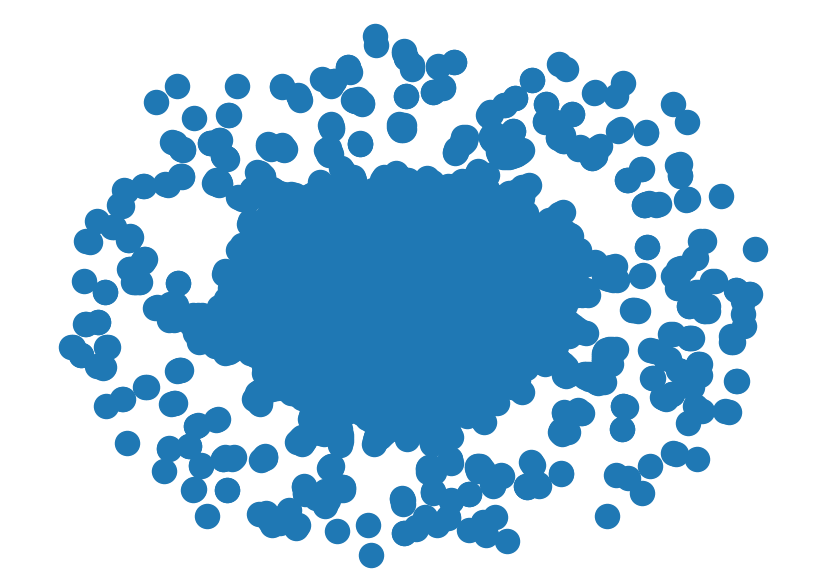

In [188]:
plt.show()

# OSMnx

# Abandoned approaches

## Reading just the street list containing single connections

In [ ]:
# def bsd_txt_to_intersections_basic(street_file_path):
#     with open(street_file_path) as file:
#         streets = file.readlines()
    
#     df_intersection_gather = pd.DataFrame(columns=['street_id', 'street_name', 'off_street_name'])
        
#     for line in streets:
#         if ', see ' in line:
#             continue # ignore sub-streets for now
#         elif ', ' in line:
#             df_intersection_gather.loc[len(df_intersection_gather)] = {
#                 'street_id': len(df_intersection_gather),
#                 'street_name': line.split(', ')[0],
#                 'off_street_name': line.split(', ')[1].strip()
#             }

#     return df_intersection_gather

# df_off_street = bsd_txt_to_intersections_basic('./data/1877-BSD-streets-only')
# df_off_street

,street_id,street_name,off_street_name
0,0,Abbey Street,Peter's Hill
1,1,Abbey Street West,St. Paul Street
2,2,Abbot Street,Peveril Street
3,3,Abercorn Basin,Queen's Quay
4,4,Abercorn Cottages,Ballymacarrett
...,...,...,...
1180,1180,York Street,Donegall Street
1181,1181,York Street Little,Patrick Street Great
1182,1182,Young's Place,Newtownards Road
1183,1183,Young's Row,Ballymacarrett


/tmp/ipykernel_26143/393047237.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_matrix = pd.crosstab(df['street_name'], df['off_street_name']).applymap(lambda x: 1 if x > 0 else 0)


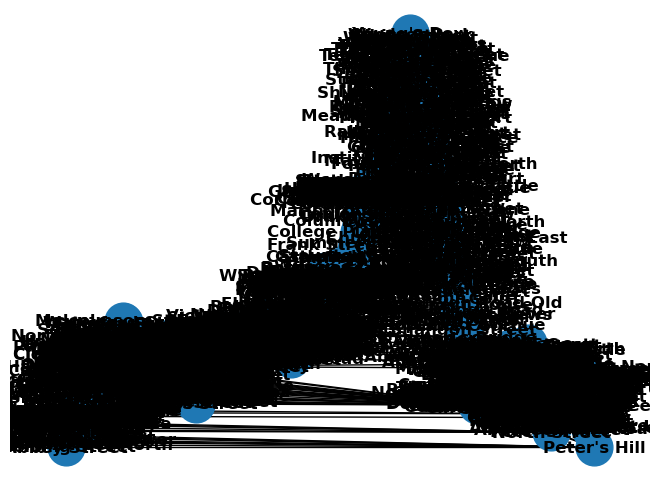

In [ ]:
df = df_off_street
df.drop('street_id', axis=1, inplace=True)

# use crosstab to make a format compatible with adjacency matrix of NetworkX
binary_matrix = pd.crosstab(df['street_name'], df['off_street_name']).applymap(lambda x: 1 if x > 0 else 0)

# make sure it's square (ie all values are in x and y)
binary_matrix = binary_matrix.reindex(columns=df['street_name'].unique(), fill_value=0)

# create graph object
G = nx.from_pandas_adjacency(binary_matrix)

# draw the graph
pos = nx.planar_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700)

# show the graph
plt.show() #TODO: check interaction between nx.draw and plt.show


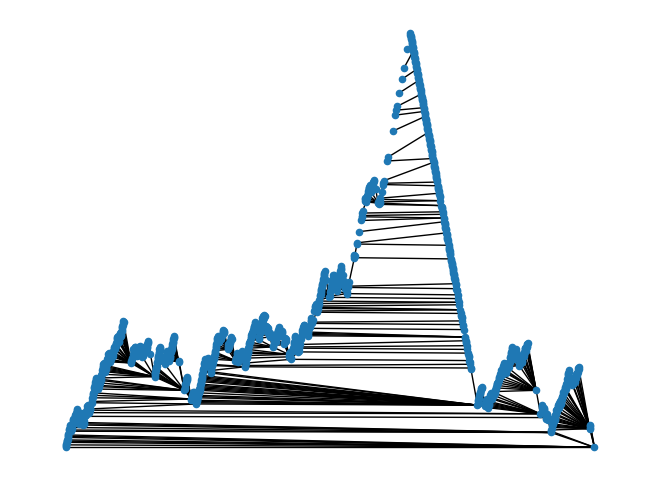

In [ ]:
nx.draw_planar(G, with_labels=False, font_weight='bold', node_size=20)


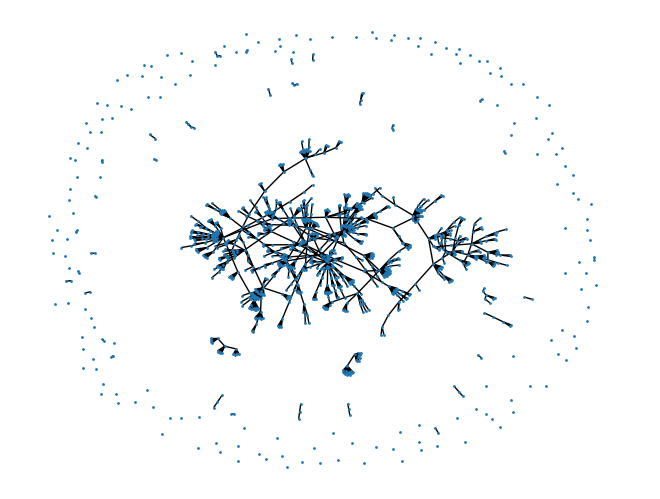

In [ ]:
nx.draw(G, with_labels=False, font_weight='bold', node_size=1)
#plt.show()

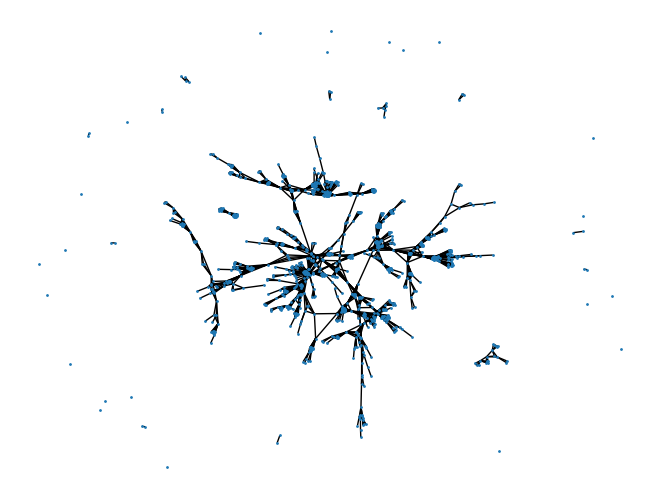

In [ ]:
L=nx.line_graph(G)
nx.draw(L, node_size=1)


''The Node identifiers in your graph are the strings (e.g., 'NP'). Since you can't have two different nodes with the same identifier, different instances of the same string collide. You can solve it by separating the node's identifier and node's string. Keep a unique integer to identify each node, and map it to the appropriate string.'' https://stackoverflow.com/questions/53997298/allowing-duplicate-nodes-in-networkx-preventing-a-node-from-having-two-parents

## Too much regex, too soon